In [1]:
%matplotlib inline


# Handling of no-data in Lucas-Kanade

Areas of missing data in radar images are typically caused by visibility limits
such as beam blockage and the radar coverage itself. These artifacts can mislead
the echo tracking algorithms. For instance, precipitation leaving the domain
might be erroneously detected as having nearly stationary velocity.

This example shows how the Lucas-Kanade algorithm can be tuned to avoid the
erroneous interpretation of velocities near the maximum range of the radars by
buffering the no-data mask in the radar image in order to exclude all vectors
detected nearby no-data areas.


In [2]:
from datetime import datetime
from matplotlib import cm, colors

import matplotlib.pyplot as plt
import numpy as np

from pysteps import io, motion, nowcasts, rcparams, verification
from pysteps.utils import conversion, transformation
from pysteps.visualization import plot_precip_field, quiver

Pysteps configuration file found at: /home/runner/.pysteps/pystepsrc



## Read the radar input images

First, we will import the sequence of radar composites.
You need the pysteps-data archive downloaded and the pystepsrc file
configured with the data_source paths pointing to data folders.



In [3]:
# Selected case
date = datetime.strptime("201607112100", "%Y%m%d%H%M")
data_source = rcparams.data_sources["mch"]

### Load the data from the archive



In [4]:
root_path = data_source["root_path"]
path_fmt = data_source["path_fmt"]
fn_pattern = data_source["fn_pattern"]
fn_ext = data_source["fn_ext"]
importer_name = data_source["importer"]
importer_kwargs = data_source["importer_kwargs"]
timestep = data_source["timestep"]

# Find the two input files from the archive
fns = io.archive.find_by_date(
    date, root_path, path_fmt, fn_pattern, fn_ext, timestep=5, num_prev_files=1
)

# Read the radar composites
importer = io.get_method(importer_name, "importer")
R, quality, metadata = io.read_timeseries(fns, importer, **importer_kwargs)

del quality  # Not used

### Preprocess the data



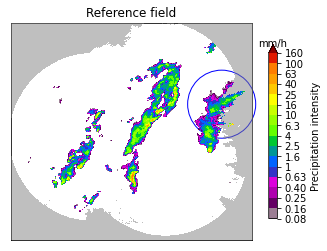

In [5]:
# Convert to mm/h
R, metadata = conversion.to_rainrate(R, metadata)

# Keep the reference frame in mm/h and its mask (for plotting purposes)
ref_mm = R[0, :, :].copy()
mask = np.ones(ref_mm.shape)
mask[~np.isnan(ref_mm)] = np.nan

# Log-transform the data [dBR]
R, metadata = transformation.dB_transform(R, metadata, threshold=0.1, zerovalue=-15.0)

# Keep the reference frame in dBR (for plotting purposes)
ref_dbr = R[0].copy()
ref_dbr[ref_dbr < -10] = np.nan

# Plot the reference field
plot_precip_field(ref_mm, title="Reference field")
circle = plt.Circle((620, 400), 100, color="b", clip_on=False, fill=False)
plt.gca().add_artist(circle)
plt.show()

Notice the "half-in, half-out" precipitation area within the blue circle.
As we are going to show next, the tracking algorithm can erroneously interpret
precipitation leaving the domain as stationary motion.

Also note that the radar image includes NaNs in areas of missing data.
These are used by the optical flow algorithm to define the radar mask.

## Sparse Lucas-Kanade

By setting the optional argument ``dense=False`` in ``xy, uv = dense_lucaskanade(...)``,
the LK algorithm returns the motion vectors detected by the Lucas-Kanade scheme
without interpolating them on the grid.
This allows us to better identify the presence of wrongly detected
stationary motion in areas where precipitation is leaving the domain (look
for the red dots within the blue circle in the figure below).



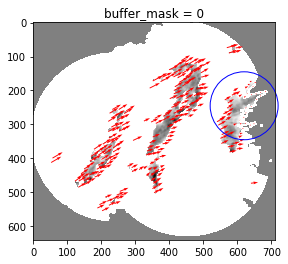

In [6]:
# Get Lucas-Kanade optical flow method
dense_lucaskanade = motion.get_method("LK")

# Mask invalid values
R = np.ma.masked_invalid(R)

# Use no buffering of the radar mask
fd_kwargs1 = {"buffer_mask": 0}
xy, uv = dense_lucaskanade(R, dense=False, fd_kwargs=fd_kwargs1)
plt.imshow(ref_dbr, cmap=plt.get_cmap("Greys"))
plt.imshow(mask, cmap=colors.ListedColormap(["black"]), alpha=0.5)
plt.quiver(
    xy[:, 0],
    xy[:, 1],
    uv[:, 0],
    uv[:, 1],
    color="red",
    angles="xy",
    scale_units="xy",
    scale=0.2,
)
circle = plt.Circle((620, 245), 100, color="b", clip_on=False, fill=False)
plt.gca().add_artist(circle)
plt.title("buffer_mask = 0")
plt.show()

The LK algorithm cannot distinguish missing values from no precipitation, that is,
no-data are the same as no-echoes. As a result, the fixed boundaries produced
by precipitation in contact with no-data areas are interpreted as stationary motion.
One way to mitigate this effect of the boundaries is to introduce a slight buffer
of the no-data mask so that the algorithm will ignore all the portions of the
radar domain that are nearby no-data areas.
This buffer can be set by the keyword argument ``buffer_mask`` within the
feature detection optional arguments ``fd_kwargs``.
Note that by default ``dense_lucaskanade`` uses a 5-pixel buffer.



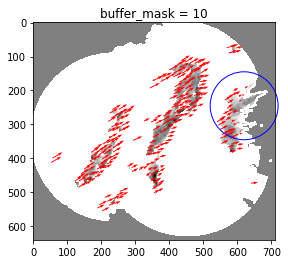

In [7]:
# with buffer
buffer = 10
fd_kwargs2 = {"buffer_mask": buffer}
xy, uv = dense_lucaskanade(R, dense=False, fd_kwargs=fd_kwargs2)
plt.imshow(ref_dbr, cmap=plt.get_cmap("Greys"))
plt.imshow(mask, cmap=colors.ListedColormap(["black"]), alpha=0.5)
plt.quiver(
    xy[:, 0],
    xy[:, 1],
    uv[:, 0],
    uv[:, 1],
    color="red",
    angles="xy",
    scale_units="xy",
    scale=0.2,
)
circle = plt.Circle((620, 245), 100, color="b", clip_on=False, fill=False)
plt.gca().add_artist(circle)
plt.title("buffer_mask = %i" % buffer)
plt.show()

## Dense Lucas-Kanade

The above displacement vectors produced by the Lucas-Kanade method are now
interpolated to produce a full field of motion (i.e., ``dense=True``).
By comparing the velocity of the motion fields, we can easily notice
the negative bias that is introduced by the the erroneous interpretation of
velocities near the maximum range of the radars.



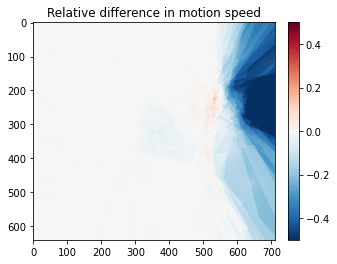

In [8]:
UV1 = dense_lucaskanade(R, dense=True, fd_kwargs=fd_kwargs1)
UV2 = dense_lucaskanade(R, dense=True, fd_kwargs=fd_kwargs2)

V1 = np.sqrt(UV1[0] ** 2 + UV1[1] ** 2)
V2 = np.sqrt(UV2[0] ** 2 + UV2[1] ** 2)

plt.imshow((V1 - V2) / V2, cmap=cm.RdBu_r, vmin=-0.5, vmax=0.5)
plt.colorbar(fraction=0.04, pad=0.04)
plt.title("Relative difference in motion speed")
plt.show()

Notice how the presence of erroneous velocity vectors produces a significantly
slower motion field near the right edge of the domain.

## Forecast skill

We are now going to evaluate the benefit of buffering the radar mask by computing
the forecast skill in terms of the Spearman correlation coefficient.
The extrapolation forecasts are computed using the dense UV motion fields
estimated above.



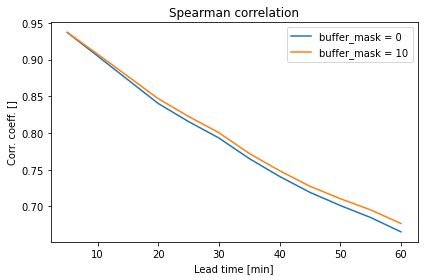

In [9]:
# Get the advection routine and extrapolate the last radar frame by 12 time steps
# (i.e., 1 hour lead time)
extrapolate = nowcasts.get_method("extrapolation")
R[~np.isfinite(R)] = metadata["zerovalue"]
R_f1 = extrapolate(R[-1], UV1, 12)
R_f2 = extrapolate(R[-1], UV2, 12)

# Back-transform to rain rate
R_f1 = transformation.dB_transform(R_f1, threshold=-10.0, inverse=True)[0]
R_f2 = transformation.dB_transform(R_f2, threshold=-10.0, inverse=True)[0]

# Find the veriyfing observations in the archive
fns = io.archive.find_by_date(
    date, root_path, path_fmt, fn_pattern, fn_ext, timestep=5, num_next_files=12
)

# Read and convert the radar composites
R_o, _, metadata_o = io.read_timeseries(fns, importer, **importer_kwargs)
R_o, metadata_o = conversion.to_rainrate(R_o, metadata_o)

# Compute Spearman correlation
skill = verification.get_method("corr_s")
score_1 = []
score_2 = []
for i in range(12):
    score_1.append(skill(R_f1[i, :, :], R_o[i + 1, :, :])["corr_s"])
    score_2.append(skill(R_f2[i, :, :], R_o[i + 1, :, :])["corr_s"])

x = (np.arange(12) + 1) * 5  # [min]
plt.plot(x, score_1, label="buffer_mask = 0")
plt.plot(x, score_2, label="buffer_mask = %i" % buffer)
plt.legend()
plt.xlabel("Lead time [min]")
plt.ylabel("Corr. coeff. []")
plt.title("Spearman correlation")

plt.tight_layout()
plt.show()

As expected, the corrected motion field produces better forecast skill already
within the first hour into the nowcast.



In [10]:
# sphinx_gallery_thumbnail_number = 2